In [88]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import numpy as np

## Graph generation, processing and analysis functions

In [89]:
def create_graph(num_nodes, num_edges, node_value_range = [0, 100], edge_weight_range = [0,1], nb_of_sources = 0, nb_of_sinks = 0, tips_are_sources_or_sinks = True):
    """
    Creates a single component random graph with the specified number of nodes and edges.
    The value of each node is randomly selected from the range specified by node_value_range.
    The weight of each edge is randomly selected from the range specified by edge_weight_range.
    """
    G = nx.Graph()

    # Create nodes with random values
    for node in range(1, num_nodes + 1):
        G.add_node(node, value=random.uniform(node_value_range[0], node_value_range[1]))

    if nb_of_sources > 0:
        #Randomly select 'nb_of_sources' nodes to be sources (i.e. have value to node_value_range[1])
        sources = random.sample(range(1, num_nodes + 1), nb_of_sources)
        for source in sources:
            print("Added source: ", source)
            G.nodes[source]['value'] = node_value_range[1]
        
    if nb_of_sinks > 0:
        #Randomly select 'nb_of_sinks' nodes to be sinks (i.e. have value to node_value_range[0]), out of the nodes that are not sources
        sinks = random.sample([node for node in range(1, num_nodes + 1) if node not in sources], nb_of_sinks)
        for sink in sinks:
            print("Added sink: ", sink)
            G.nodes[sink]['value'] = node_value_range[0]
                    

    # Create a list of all possible edges
    possible_edges = [(i, j) for i in range(1, num_nodes + 1) for j in range(i + 1, num_nodes + 1)]

    # Randomly select 'num_edges' edges from the possible edges list
    selected_edges = random.sample(possible_edges, min(num_edges, len(possible_edges)))

    # Add the selected edges to the graph
    G.add_edges_from(selected_edges)

    #Give each edge a random weight
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = random.uniform(edge_weight_range[0], edge_weight_range[1])

    #Make sure the graph is connected
    if not nx.is_connected(G):
        G = create_graph(num_nodes, num_edges, node_value_range, edge_weight_range)

    #If tips_are_sources_or_sinks is True, make sure that the tips (i.e. nodes with degree 1) are either sources or sinks
    tip_counter = 0
    if tips_are_sources_or_sinks:
        #Make sure that the tips (i.e. nodes with degree 1) are either sources or sinks
        for node in G.nodes():
            if G.degree(node) == 1:
                tip_counter += 1
                #Set the value of the node either to node_value_range[1] or node_value_range[0]
                G.nodes[node]['value'] = node_value_range[1] if tip_counter % 2 == 0 else node_value_range[0]


    #Create a layout for the graph
    pos = nx.spring_layout(G)

    #Set the position of each node as an attribute
    for node in G.nodes():
        G.nodes[node]['pos'] = list(pos[node])
        
    return G

In [90]:
def graph_stats(G):
    #Compute the mean and standard deviation of the node values
    node_values = [G.nodes[node]['value'] for node in G.nodes()]
    mean_node_value = np.mean(node_values)
    std_node_value = np.std(node_values)
    return mean_node_value, std_node_value


def signal_smoothness_on_graph(G):
    #Get the Laplacian matrix of the graph
    L = nx.laplacian_matrix(G)
    L = L.toarray()

    #Get the signal values of the nodes
    node_values = [G.nodes[node]['value'] for node in G.nodes()]
    u = np.array(node_values)

    #Compute the quadratic form of the Laplacian matrix and the signal values
    quadratic_form = np.dot(np.dot(u, L), u)
    return quadratic_form

In [91]:
def plot_graph(G, value_range=[0,100], labels=True):
    node_values = nx.get_node_attributes(G, 'value')
    node_colors = [node_values[node] for node in G.nodes()]

    # Define a colormap and normalize the node values to it
    cmap = cm.plasma
    vmin = value_range[0]
    vmax = value_range[1]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    # Create figure and axis for the graph
    fig, ax = plt.subplots()

    # Get the pos of each node in the graph using the 'pos' attribute
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw nodes using colors mapped to values
    node_size = 5000 / len(G.nodes())
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=cmap, node_size=node_size, vmin=vmin, vmax=vmax)
    nodes.set_norm(norm)

    # Draw edges and labels with the width corresponding to the edge weight

    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()])

    if labels:
        labels = {node: f"({node})\n{node_values[node]:.2f}" for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=labels, font_color='black')


    # Create colorbar axis
    cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])  # Adjust position and size as needed
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Signal amplitude')

    plt.show()

In [92]:
def sample_signal_from_graph(G, num_samples = 5, sampling_noise_std = 0.2):
    samples = []
    for i in range(num_samples):
        #Get all the values of the nodes in the graph
        node_values = [G.nodes[node]['value'] for node in G.nodes()]

        #Add gaussian noise to the values
        node_values = [value + random.gauss(0, sampling_noise_std) for value in node_values]

        #Add the values to the result
        samples.append(node_values)

    #Return the result as a numpy array
    return np.array(samples)
    

In [93]:
def diffusion(G, diffusion_strength = 0.1, diffusion_steps = 10, value_range = [0, 100]):
    #Theoretical derivation: https://www.math.fsu.edu/~bertram/lectures/Diffusion.pdf

    #Create a copy of the graph
    G = G.copy()

    #Get the Laplacian matrix and convert it to a numpy array
    L = nx.laplacian_matrix(G)
    L = L.toarray()
    
    #Compute the eigenvalues and eigenvectors of the Laplacian
    eigenvalues, eigenvectors = np.linalg.eig(L)

    #Get the initial signal u_0:
    u_0 = np.array([[G.nodes[node]['value']] for node in G.nodes()])
    # print("u_0: ", list(u_0))

    #Get the initial a:
    a_0 = np.array([np.dot(eigenvectors[:, i], u_0) / np.dot(eigenvectors[:, i], eigenvectors[:, i]) for i in range(len(eigenvalues))])
    # print("a_0: ", list(a_0))

    #Reconstruct the initial signal u_0 from the eigenvectors and a_0
    # u_0_reconstructed = np.sum([a_0[i] * eigenvectors[:, i] for i in range(len(eigenvalues))], axis=0)
    # print("u_0_reconstructed: ", list(u_0_reconstructed))
    
    #Write the signal at time t as a linear combination of the eigenvectors of the Laplacian with exponentially decaying coefficients
    u_t = np.sum([a_0[i] * np.exp(-eigenvalues[i] * diffusion_steps * diffusion_strength) * eigenvectors[:, i] for i in range(len(eigenvalues))], axis=0)
    # print("u_t: ", list(u_t))

    #Update the node values
    for i, node in enumerate(G.nodes()):
        G.nodes[node]['value'] = u_t[i]
        
    return G

# Sample generation and diffusion of a graph

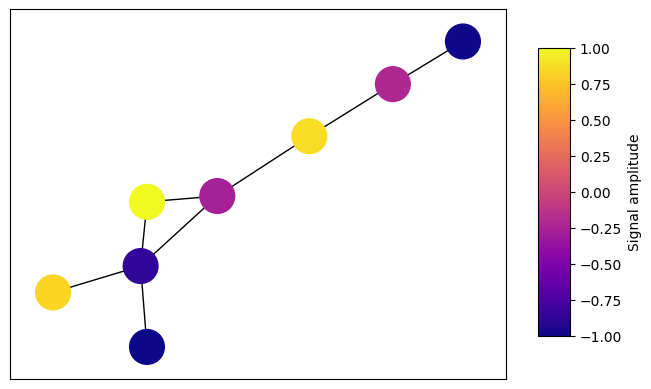

Mean and std:  (-0.1332757353685505, 0.9133424097168068)
Laplacian quadratic form:  12.882851840660312


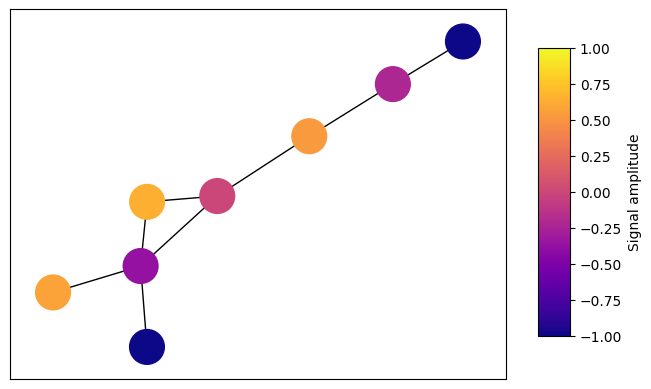

Mean and std:  (-0.13327573536855047, 0.6656003594835069)
Laplacian quadratic form:  4.651442269949824


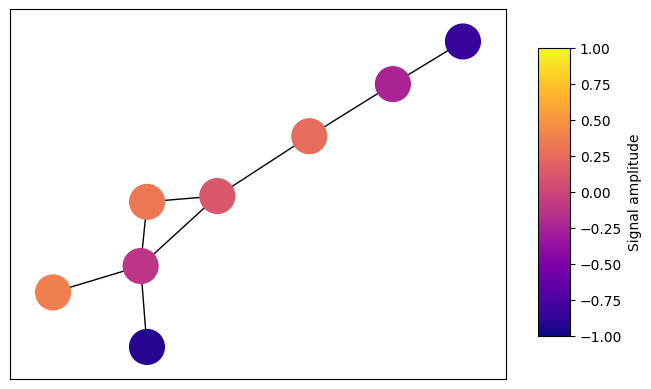

Mean and std:  (-0.13327573536855047, 0.47590936804452655)
Laplacian quadratic form:  1.8061387896093357


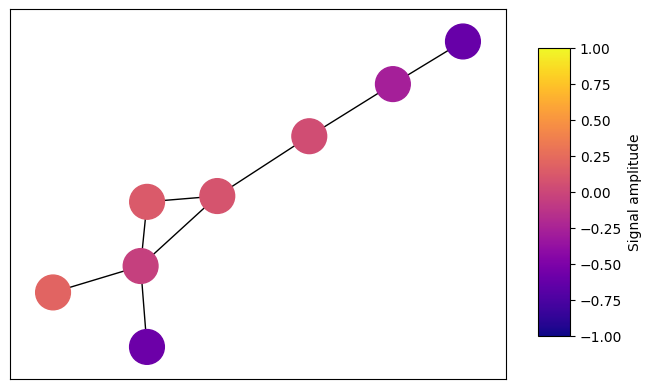

Mean and std:  (-0.13327573536855042, 0.3006856757704314)
Laplacian quadratic form:  0.6214559264571261


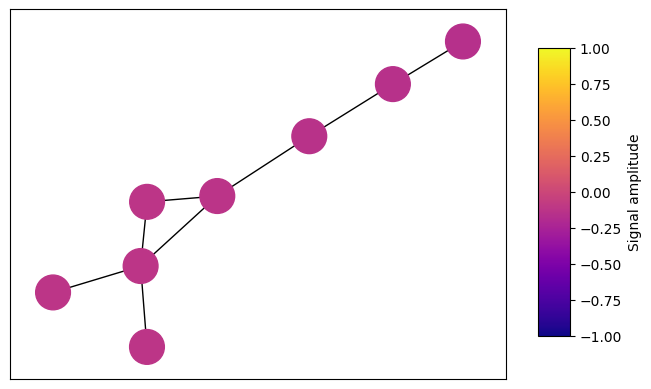

Mean and std:  (-0.13327573536855014, 0.015588818486805383)
Laplacian quadratic form:  0.0004635609807678593


In [94]:
# Input parameters
num_nodes = 8
num_edges = 8
value_range = (-1, 1)
diffusion_timesteps = [0, 2, 5, 10, 100]

# Create the graph
G0 = create_graph(num_nodes, num_edges, value_range, edge_weight_range = [1,1])

# Perform diffusion and plot the graph at each timestep
for t in diffusion_timesteps:
    G = diffusion(G0,  diffusion_steps = t)
    plot_graph(G, labels=False, value_range=value_range)
    print("Mean and std: ", graph_stats(G))
    print("Laplacian quadratic form: ", signal_smoothness_on_graph(G))


In [95]:
#Sample the signal from the graph
samples = sample_signal_from_graph(G0, num_samples = 20, sampling_noise_std = 0.2)
print("Samples shape: ", samples.shape)
print("Samples: ", samples)

Samples shape:  (20, 8)
Samples:  [[-0.72935042 -0.12702458  1.1990369   0.45915224 -0.51697766 -0.88047837
   0.66623293 -0.58116038]
 [-1.04321094 -0.66981545  0.6462786   0.78803492 -0.99725226 -1.1605847
   0.99790517 -0.21236608]
 [-0.35681487 -0.54128391  0.76242983  0.41664556 -0.93152238 -0.55066792
   1.05177546 -0.3434356 ]
 [-0.71203582 -0.36171028  0.99435278  0.89815977 -0.73710968 -1.33466026
   1.15850661 -0.41353929]
 [-0.97579627 -0.15127944  0.90571939  0.47197122 -0.97650464 -0.82911634
   1.00779418 -0.23234743]
 [-1.12158278 -0.48475492  1.3213337   0.31750271 -0.67620511 -0.82552639
   0.85045393 -0.21473136]
 [-0.97357378 -0.64579388  1.24017733  1.19392231 -0.81042325 -0.86779328
   0.99730502  0.01140899]
 [-1.32893569 -0.42509734  0.91996061  0.5125636  -1.23680215 -0.8932125
   0.63585968 -0.03736528]
 [-0.71092196 -0.38999139  1.23419037  0.51435225 -0.48562154 -0.95860554
   0.97383072 -0.42905207]
 [-1.02392019 -0.32906586  0.80345823  0.57267636 -0.825252

In [96]:
import os,sys
sys.path.append(os.path.realpath('FGW distance on graph/lib'))
from graph import Graph
from ot_distances import Fused_Gromov_Wasserstein_distance

In [97]:
g1 = Graph(G0)
g2 = Graph(G)


dgw=Fused_Gromov_Wasserstein_distance(alpha=0.5,features_metric='dirac',method='shortest_path').graph_d(g1,g2)
print("dgw: ", dgw)

dgw2=Fused_Gromov_Wasserstein_distance(alpha=0.5,features_metric='dirac',method='shortest_path').graph_d(g1,g1)
print("dgw2: ", dgw2)

dgw3=Fused_Gromov_Wasserstein_distance(alpha=0.5,features_metric='dirac',method='shortest_path').graph_d(g2,g2)
print("dgw3: ", dgw3)

dgw:  0.5000000000034845
dgw2:  3.906446514845189e-12
dgw3:  3.922071514845189e-12


In [98]:
nb_graphs = 10  # Number of graphs to generate and test on
num_nodes = 8  # Number of nodes in each graph
num_edges = 8  # Number of edges in each graph
node_value_range = [-1, 1]  # Range of values that each node can take
edge_weight_range = [1, 1]  # Range of weights that each edge can take

diffusion_steps = np.logspace(0, 1.5, 25)  # Number of diffusion steps to test on

# Build the ground truth and reconstructed graphs for each diffusion step
gt_graphs = [[] for _ in range(len(diffusion_steps))]
reconstructed_graphs = [[] for _ in range(len(diffusion_steps))]
for i in range(nb_graphs):
    # Create a graph
    G0 = create_graph(num_nodes, num_edges, node_value_range, edge_weight_range = edge_weight_range)

    # Perform diffusion and plot the graph at each timestep
    for j, t in enumerate(diffusion_steps):
        G = diffusion(G0,  diffusion_steps = t)
        gt_graphs[j].append(G)

        #Sample the signal from the graph
        samples = sample_signal_from_graph(G, num_samples = 20, sampling_noise_std = 0.2)
        
        #Reconstruct the graph from the samples
        #TODO: PERFORM RECONSTRUCTION USING THE LEARNED GRAPH LAPLACIAN TECHNIQUE
        reconstructed_graphs[j].append(G) #TODO: REPLACE THIS WITH THE RECONSTRUCTED GRAPH


In [99]:
#Compute the distances between the ground truth and reconstructed graphs using Fused Gromov-Wasserstein distance
distances = np.zeros((len(diffusion_steps), nb_graphs))
for i in range(len(diffusion_steps)):
    for j in range(nb_graphs):
        distances[i, j] = Fused_Gromov_Wasserstein_distance(alpha=0.5,features_metric='dirac',method='shortest_path').graph_d(Graph(gt_graphs[i][j]), Graph(reconstructed_graphs[i][j]))


# Compute the smoothness of the signal on each graph
smoothnesses = np.zeros((len(diffusion_steps), nb_graphs))
for i, graphs in enumerate(gt_graphs):
    for j, graph in enumerate(graphs):
        smoothnesses[i, j] = signal_smoothness_on_graph(graph)



Text(0.5, 1.0, 'Smoothness of the signal on a graph\nw.r.t. the diffusion steps')

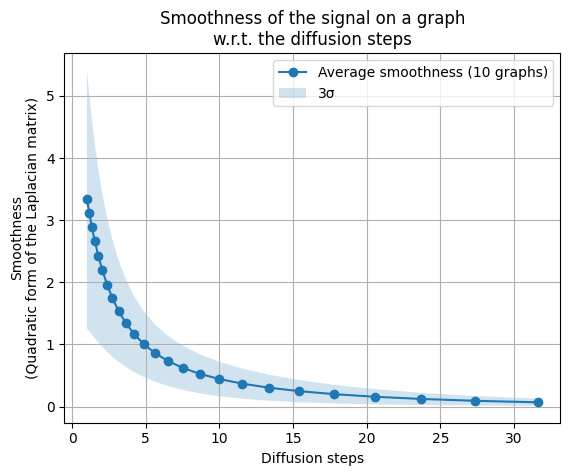

In [105]:
#Plot the average and std for the quadratic form of the Laplacian matrix of each graph per diffusion step as a continuous line and a shaded area respectively
plt.plot(diffusion_steps, np.mean(smoothnesses, axis=1), marker='o', label=f'Average smoothness ({nb_graphs} graphs)')
plt.fill_between(diffusion_steps, np.mean(smoothnesses, axis=1) - 1.5 * np.std(smoothnesses, axis=1), np.mean(smoothnesses, axis=1) + 1.5 * np.std(smoothnesses, axis=1), alpha=0.2, label='3σ')
#Add a legend to explain the shaded area
plt.legend()
plt.xlabel("Diffusion steps")
plt.ylabel("Smoothness\n(Quadratic form of the Laplacian matrix)")
#Add a grid to the plot
plt.grid()
plt.title("Smoothness of the signal on a graph\nw.r.t. the diffusion steps")



Text(0.5, 1.0, 'Distance between the ground truth and reconstructed graphs\nw.r.t. the smoothness of the signal on the graph')

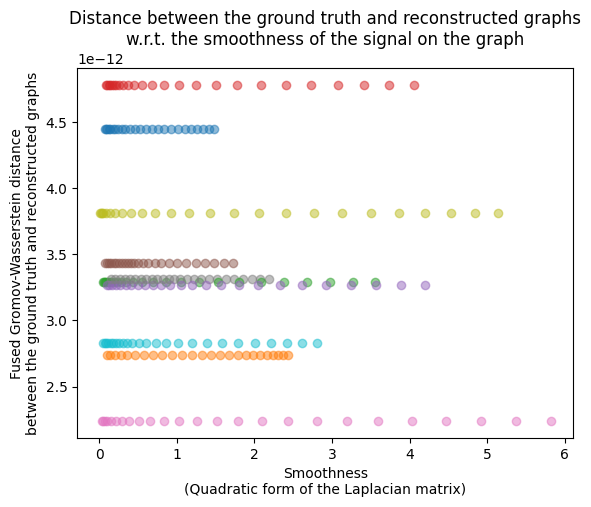

In [106]:
# Scatter plot the distance between the ground truth and reconstructed graphs per smoothness for each pair of graphs
for i in range(len(diffusion_steps)):
    for j in range(nb_graphs):
        plt.scatter(smoothnesses[i, j], distances[i, j], alpha=0.5)

plt.xlabel("Smoothness\n(Quadratic form of the Laplacian matrix)")
plt.ylabel("Fused Gromov-Wasserstein distance\nbetween the ground truth and reconstructed graphs")
plt.title("Distance between the ground truth and reconstructed graphs\nw.r.t. the smoothness of the signal on the graph")